# 📈 Cryptocurrency Price Movement Classifier

Cryptocurrency markets are known for their high volatility and rapid price swings, making them both exiting and risky for investors. In this notebook, we aim to build a simple yet effective machine learning model to classify wether the price of a cryptocurrency — specifically Bitcoin (BTC) — is likely to go up or down in the near term.  

## 🎯 Objective
Use historical price data and technical indicators to **predict short-term price direction **. By leveraging financial metrics such as **Exponential Moving Averages (EMA)** or **Relative Strength Index (RSI)** among others, we aim to detect signals that may precede price changes.

## ⚙️ Methodology

1. **Data Collection**: We retrieve historical price data using the `yfinance` API.
2. **Feature Engineering**: We calculate popular technical indicators such as EMA and RSI.
3. **Labeling**: We define a binary target — 1 if the price goes up the next day, 0 otherwise.
4. **Modeling**: We train a `RandomForestClassifier` to predict price movement using our features.
5. **Evaluation**: We assess the model's performance using accuracy and classification metrics.


In [100]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
plt.style.use('fivethirtyeight')

## 📥 Data collection

We use `yfinance` to fetch historical data for Bitcoin.**bold text**

In [2]:
df = yf.download(["BTC"], start='2021-03-25', end='2025-04-13', auto_adjust=False, multi_level_index=False).reset_index()

[*********************100%***********************]  1 of 1 completed


In [3]:
df

,Date,Adj Close,Close,High,Low,Open,Volume
0,2024-07-31,28.950001,28.950001,29.650000,28.799999,29.500000,930940
1,2024-08-01,28.100000,28.100000,28.799999,27.600000,28.650000,8564500
2,2024-08-02,27.799999,27.799999,29.049999,27.650000,28.750000,2412560
3,2024-08-05,23.750000,23.750000,24.650000,22.000000,22.049999,3141140
4,2024-08-06,25.250000,25.250000,25.350000,24.150000,24.500000,1690140
...,...,...,...,...,...,...,...
171,2025-04-07,34.529999,34.529999,35.959999,33.529999,34.020000,2505900
172,2025-04-08,33.990002,33.990002,35.570000,33.759998,35.509998,1369900
173,2025-04-09,36.500000,36.500000,36.779999,33.980000,33.980000,2034400
174,2025-04-10,35.230000,35.230000,36.240002,34.705002,36.189999,2292200


## 🔧 Feature Engineering
Technical indicators functions are implemented in this section:

1.   Exponential Moving Average (EMA)
2.   Moving Average Convergence Divergence
3.   Bollinger Bands
4.   Relative Strenght Index (RSI)


### Exponential Moving Averange indicator (EMA)

Is a type of moving average that gives more weight to recent data points compared to older ones, making it more responsive to recent price changes.

EMAs help traders identify the direction and strength of a trend by smoothing out short-term fluctuations.

When the price crosses above the EMA in an uptrend, it may be a signal to enter a long position, while crossing below in a downtrend may indicate a short position. EMAs are often used in conjunction with other technical indicators for a more comprehensive analysis.

In [41]:
#EMA Function (Exponential Moving Average indicator)
def EMA(data, period=20, column='Close'):
  return data[column].ewm(span=period, adjust=False).mean()

### Moving Average Convergence Divergence
MACD shows the relationship between 3 EMAs — typically 12 and 26 period — to capture momentum shifts. The reason why 12 and 26 is use, is because they represent the difference between short and long-term trends. 12 matches typically a bi-weekly signal while 26 a monthly cycle in the stock market.

Moreover, there is a smoothed version of the MACD line, which is known as the signal line, which is the 9-day EMA. This Signal Line helps to smooth out the MACD line so it reaches slightly slower. Through empirical testing, they found that a 9-period EMA of MACD gave a good balance: Not too slow (won’t miss early momentum shifts) and not too fast (doesn’t overreact to noise).

When:
- MACD crosses above the signal line → BUY (Bullish)
-MACD crosses below the signal line → SELL (Bearish)

The MACD line is calculated by substracting the 26-day EMA from the 12-day EMA, and the signal like is a 9-day EMA of the MACD line.

We usually accompany these line visualisations with a histogram, which shows the distance between the MACD and the Signal Line. It helps to visualise the strength of momentum.
- Histogram growing positively → bullish momentum increasing.
- Histogram growing negavively (bars decreasing in height below the zero line) → berish momemtum increasing.
- Histogram shinking (bars are becoming shorted) → momentum weakening.

**But why do we need both (histograms and lines) ?**

MACD line and histogram don't always move in sync. The histogram measures th egap between the MACD and the Signal. So it reacts faster to changes in MACD.

The signal line is a smoothed average of the MACD line. That smoothing introduces lag — it’s slower to react than the MACD itself. This causes the histogram to spike/dip before the MACD visibly crosses over the signal.

Therefore the **HISTOGRAM LEADS, MACD CONFIRMS**
Many traders use the histogram to anticipate changes in momentum. Histogram shrinking toward zero = signal line and MACD line are about to cross.

In [45]:
# Estimate MACD
df['EMA_12'] = EMA(df, period=12)
df['EMA_26'] = EMA(df, period=26)
df['MACD'] = df['EMA_12'] - df['EMA_26']

# Signal line
df['MACD_Signal'] = EMA(df, period=9, column='MACD')

# Histogram
df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

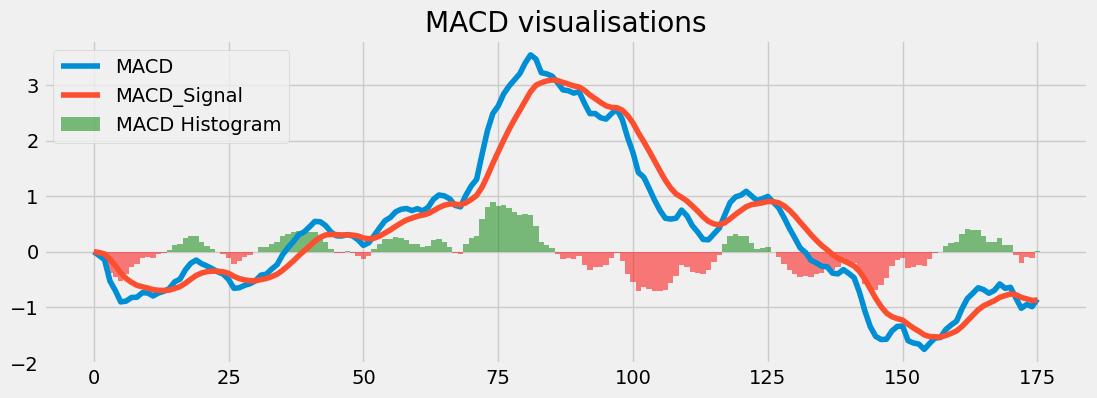

In [50]:
# Visualise MACD
plt.figure(figsize=(12,4))
plt.plot(df['MACD'], label='MACD')
plt.plot(df['MACD_Signal'], label='MACD_Signal')
plt.bar(df.index, df['MACD_Hist'], label='MACD Histogram', color=np.where(df['MACD_Hist'] >= 0, 'green', 'red'), width=1.0, alpha=0.5)
plt.title('MACD visualisations')
plt.legend(['MACD', 'MACD_Signal', 'MACD Histogram'], loc='upper left')



### Bollinger Bands
Tool used to measure market volatility and identify potential trading opportunities. They consist of a middle lin (SMA) and an upper (SMA + std) and lower band (SMA - std). The bands expand during periods of high volatily and contract during periods of low volatility.

If the price breaks above the upper band, it might be considered overbrought, and if it breaks below the lower band, it might be considered oversold.

In [49]:
df['SMA_20'] = df["Close"].rolling(window=20).mean()
df['SMA_std'] = df["Close"].rolling(window=20).std()
df['BB_upper'] = df['SMA_20'] + (2*df['SMA_std'])
df['BB_lower'] = df['SMA_20'] - (2*df['SMA_std'])

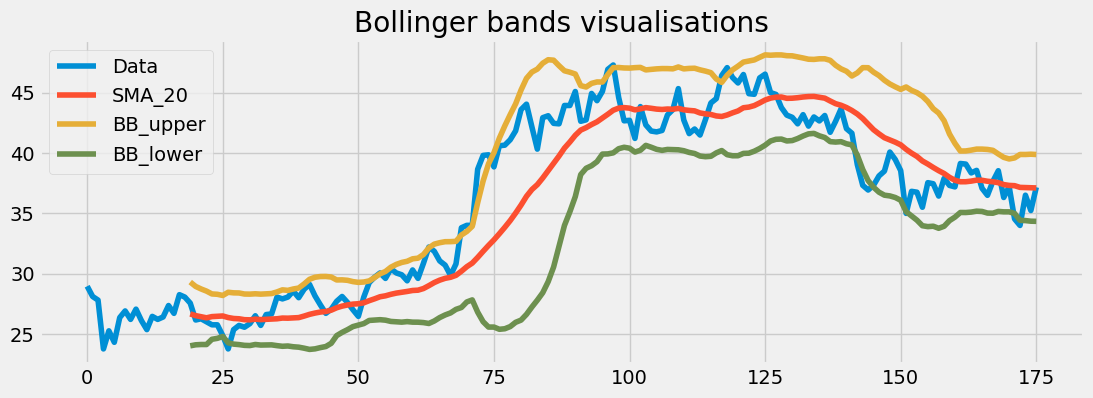

In [51]:
# Visualise data
plt.figure(figsize=(12,4))
plt.plot(df['Close'], label='Data')
plt.plot(df['SMA_20'], label='SMA_20')
plt.plot(df['BB_upper'], label='BB_upper')
plt.plot(df['BB_lower'], label='BB_lower')
plt.title('Bollinger bands visualisations')
plt.legend(['Data', 'SMA_20', 'BB_upper', 'BB_lower'], loc='upper left')



### Relative Strength Index (RSI)
Is a momentum indicator that helps to identify overbought and oversold conditionas and generates potential buy and sell signals. It's a tool used to gauge whether an asset's momentum is accelerating or decelerating, potentially indicating a trend reversal.

- Overbought: An RSI reading above 70 generally suggests an asset is overbought and may be due for a downward correction --> Best condition to sell
- Oversold:An RSI reading below 30 generally indicates an asset is oversold and may be poised for an upward rally --> Best condition to buy
- 50 level: neutral point.


In [65]:
# RSI function
def RSI(data, period=14, column="Close"):
  delta = data[column].diff()

  gain = delta.clip(lower=0)
  loss = -delta.clip(upper=0)

  data["up"] = gain
  data["down"] = loss

  AVG_Gain = EMA(data, period, column='up')
  AVG_Loss = EMA(data, period, column='down')

  RS = AVG_Gain / AVG_Loss
  RSI = 100 - (100/ (1+RS))

  data['RSI_'+str(period)] = RSI
  return data

We usually use different time windows for different insights.

- RSI-7 reacts quickly to short-term price momentum (more volatile).

- RSI-14 is the classic setting used by traders, balancing sensitivity and noise.

- RSI-15 is similar but slightly slower, offering a nuance in mid-term strength.

Same with EMA:

- EMA-15 → faster-moving average: tracks recent trends closely.

- EMA-20 → moderate trend follower.

- EMA-50 → slow-moving, captures longer-term trends.

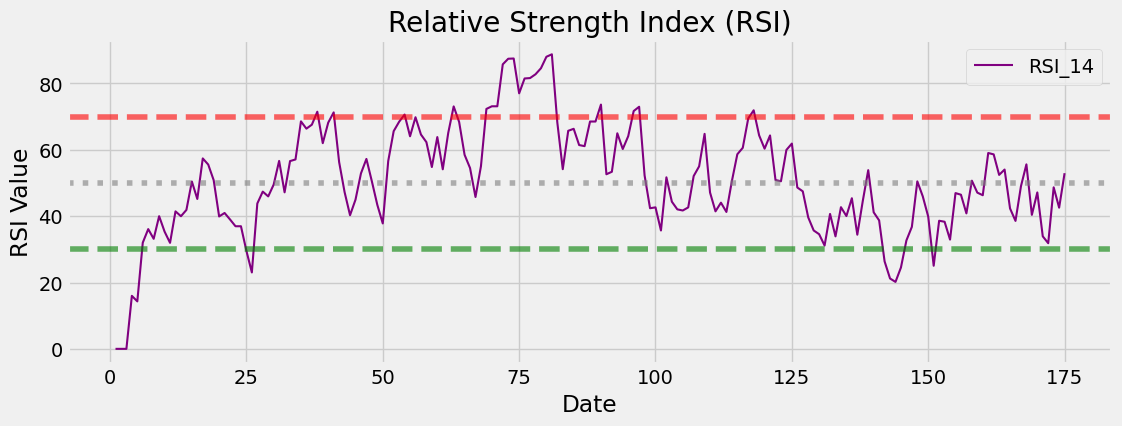

In [67]:
# Visualise for a 14 day period
RSI(df)
plt.figure(figsize=(12,4))
plt.plot(df['RSI_14'], label='RSI_14', color='purple', linewidth=1.5)
plt.axhline(70, color='red', linestyle='--', alpha=0.6)
plt.axhline(30, color='green', linestyle='--', alpha=0.6)
plt.axhline(50, color='gray', linestyle=':', alpha=0.6)
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.legend()
plt.show()

## 🏷️ Labelling

In [70]:
# Create target
# Determine if tomorrows price will be greater than todays price
# We create a target column, if greater we put 1 else 0
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

In [69]:
df

,Date,Adj Close,Close,High,Low,Open,Volume,EMA_12,EMA_26,MACD,...,MACD_Hist,SMA_20,SMA_std,BB_upper,BB_lower,up,down,RSI_14,RSI_50,Target
0,2024-07-31,28.950001,28.950001,29.650000,28.799999,29.500000,930940,28.950001,28.950001,0.000000,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2024-08-01,28.100000,28.100000,28.799999,27.600000,28.650000,8564500,28.819231,28.887038,-0.067806,...,-0.054245,NaN,NaN,NaN,NaN,0.000000,0.850000,0.000000,0.000000,0
2,2024-08-02,27.799999,27.799999,29.049999,27.650000,28.750000,2412560,28.662427,28.806516,-0.144090,...,-0.104423,NaN,NaN,NaN,NaN,0.000000,0.300001,0.000000,0.000000,0
3,2024-08-05,23.750000,23.750000,24.650000,22.000000,22.049999,3141140,27.906669,28.431960,-0.525291,...,-0.388499,NaN,NaN,NaN,NaN,0.000000,4.049999,0.000000,0.000000,1
4,2024-08-06,25.250000,25.250000,25.350000,24.150000,24.500000,1690140,27.497950,28.196259,-0.698309,...,-0.449213,NaN,NaN,NaN,NaN,1.500000,-0.000000,15.982570,-6.851877,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,2025-04-07,34.529999,34.529999,35.959999,33.529999,34.020000,2505900,37.074745,37.906253,-0.831508,...,-0.059147,37.2895,1.151221,39.591943,34.987057,0.000000,2.680000,33.923665,-244.881429,0
172,2025-04-08,33.990002,33.990002,35.570000,33.759998,35.509998,1369900,36.600169,37.616160,-1.015991,...,-0.194904,37.1480,1.365876,39.879752,34.416249,0.000000,0.539997,31.845828,-218.534079,1
173,2025-04-09,36.500000,36.500000,36.779999,33.980000,33.980000,2034400,36.584759,37.533482,-0.948723,...,-0.102109,37.1355,1.370845,39.877190,34.393811,2.509998,-0.000000,48.698496,-564.331962,0
174,2025-04-10,35.230000,35.230000,36.240002,34.705002,36.189999,2292200,36.376334,37.362854,-0.986519,...,-0.111924,37.1220,1.389008,39.900016,34.343984,0.000000,1.270000,42.555129,-359.057485,1


## 🧠 Modelling

In [73]:
keep_columns = df.drop(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'EMA_12',
       'EMA_26', 'MACD_Hist', 'SMA_std', 'up', 'down', 'Target'], axis=1).columns
X = df[keep_columns].values
Y = df["Target"].values

In [74]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

### 🌲 Random Forest
Random forest is an ensemble ML algorithm. It is based in decision trees, but instead of using one, it builds many decision tress and takes a majority vote (for classification) or average (for regression)

Since we are trying to classify price movement — whether the crypto price will go up or down — based on indicators like RSI, EMA, MACD, etc.

Random Forest is a great fit because:
- Handles nonlinear relationships: price and indicators often have complex interactions.
- Works well with small-to-medium data: crypto datasets aren't always massive
- Not sensitive to outliers: helps with noisy crypto data.
- Handles many features easily: we are using RSI, MACD ...

In [94]:
# Create the model
forest = RandomForestClassifier(n_estimators=5, criterion='entropy', random_state=1)

In [95]:
forest.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=5, random_state=1)

In [96]:
forest.score(x_test, y_test)

0.5833333333333334

In [97]:
# Forest predictions
forest_predictions = forest.predict(x_test)

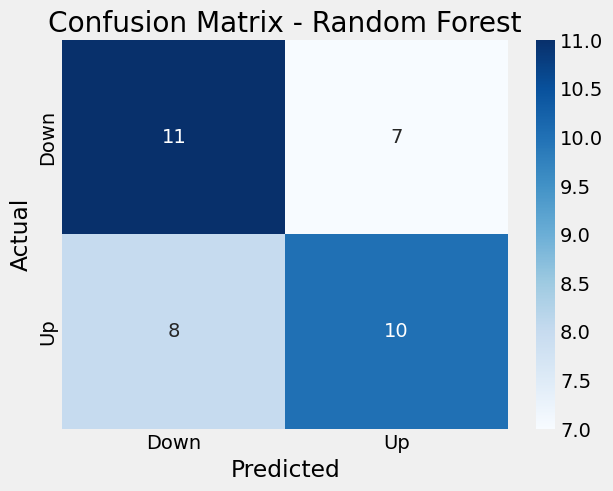

In [101]:
# Visualise data
cm = confusion_matrix(y_test, forest_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()
